# Table of contents
1. [Introduction](#introduction)
    1. [Data Description](#Data-Description)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    1. [EDA observations and recommendations](#EDA-observations-and-recommendations)
3. [Modeling](#Modeling)
    1. [Logistic Regression](#Logistic-Regression)
    2. [Random Forest](#Random-Forest)
    3. [RF model using oversampled data](#RF-model-using-oversampled-data)
    4. [Modeling Conclusion](#Modeling-Conclusion)

<a name="introduction"></a>
## Introduction
This case is about a bank (Thera Bank) which has a growing customer base. Majority of these customers are liability customers (depositors) with varying size of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors). A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns to better target marketing to increase the success ratio with a minimal budget.

The department wants to build a model that will help them identify the potential customers who have a higher probability of purchasing the loan. This will increase the success ratio while at the same time reduce the cost of the campaign.

## Goal:
1. Come up with recommendations for the product team and the marketing team to find customers who are more likely to accept personal loans
2. Build a model to predict if a customer accepte personal loan or not

### Note: 
This dataset is from [Kaggle](https://www.kaggle.com/itsmesunil/bank-loan-modelling)

In [1]:
import sqlite3 as db
import pandas as pd

In [39]:
df = pd.read_csv('UserBehavior.csv')

In [40]:
df.head(3)

,user_id,item_id,category_id,behavior,time
0,1,2268318,2520377,pv,1511544070
1,1,2333346,2520771,pv,1511561733
2,1,2576651,149192,pv,1511572885


### Add date and hour columns and remove outliers 

In [41]:
df['date_all']=pd.to_datetime(df.time.values,unit='s',utc=True).tz_convert('Asia/Shanghai')
df['date']=df['date_all'].astype('str').str[:10]
df['hour']=df['date_all'].astype('str').str[11:13]

del df['date_all']

df['hour']=df['hour'].astype('int64')
df['date']=pd.to_datetime(df['date'])

In [42]:
df.head(3)

,user_id,item_id,category_id,behavior,time,date,hour
0,1,2268318,2520377,pv,1511544070,2017-11-25,1
1,1,2333346,2520771,pv,1511561733,2017-11-25,6
2,1,2576651,149192,pv,1511572885,2017-11-25,9


In [43]:
df=df[(df['date']>='2017-11-25')&(df['date']<='2017-12-03')]

### Data set overview

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99957 entries, 0 to 100000
Data columns (total 7 columns):
user_id        99957 non-null int64
item_id        99957 non-null int64
category_id    99957 non-null int64
behavior       99957 non-null object
time           99957 non-null int64
date           99957 non-null datetime64[ns]
hour           99957 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 6.1+ MB


In [46]:
for column in df.columns:
    uniques = sorted(df[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

user_id                983	 [1, 100, 1000, 10001, 10008]
item_id              64440	 [283, 324, 330, 422, 434]
category_id           3128	 [2171, 2410, 5064, 8254, 8409]
behavior                 4	 ['buy', 'cart', 'fav', 'pv']
time                 91602	 [1511539217, 1511539222, 1511539225, 1511539227, 1511539229]
date                     9	 [numpy.datetime64('2017-11-25T00:00:00.000000000'), numpy.datetime64('2017-11-26T00:00:00.000000000'), numpy.datetime64('2017-11-27T00:00:00.000000000'), numpy.datetime64('2017-11-28T00:00:00.000000000'), numpy.datetime64('2017-11-29T00:00:00.000000000')]
hour                    24	 [0, 1, 2, 3, 4]


In [47]:
df.describe()

,user_id,item_id,category_id,time,hour
count,9.995700e+04,9.995700e+04,9.995700e+04,9.995700e+04,99957.000000
mean,9.124199e+05,2.578373e+06,2.706457e+06,1.511963e+09,15.028942
std,2.727683e+05,1.488005e+06,1.464811e+06,2.281724e+05,6.107932
min,1.000000e+00,2.830000e+02,2.171000e+03,1.511539e+09,0.000000
25%,1.000723e+06,1.295006e+06,1.331853e+06,1.511768e+09,11.000000
50%,1.001908e+06,2.577764e+06,2.733371e+06,1.511965e+09,16.000000
75%,1.003157e+06,3.864727e+06,4.145813e+06,1.512175e+09,20.000000
max,1.004381e+06,5.163001e+06,5.158474e+06,1.512317e+09,23.000000


### Save cleaned data to sql database

In [48]:
c = conn.cursor()

In [49]:
c.execute("DROP TABLE IF EXISTS user_behavior")
conn = db.connect('Users.db')
df.to_sql('user_behavior',conn)

In [186]:
query = '''
    SELECT * 
    FROM user_behavior
    LIMIT 3
'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Index','User_id','Item_id','Category_id','Behavior','Time','Date','Hour'])

,Index,User_id,Item_id,Category_id,Behavior,Time,Date,Hour
0,0,1,2268318,2520377,pv,1511544070,2017-11-25 00:00:00,1
1,1,1,2333346,2520771,pv,1511561733,2017-11-25 00:00:00,6
2,2,1,2576651,149192,pv,1511572885,2017-11-25 00:00:00,9


### Analysis using SQL

In [185]:
query = '''
    SELECT 
    (SELECT COUNT(*) FROM user_behavior WHERE behavior = 'pv') AS total_visited_pages_count, 
    COUNT(DISTINCT user_id) AS unique_users_count, 
    (SELECT COUNT(*) AS total_visited_pape_number FROM user_behavior WHERE behavior = 'pv') / 
    (SELECT COUNT(DISTINCT user_id)) AS mean_visited_pages
    FROM user_behavior

'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Total_visited_pages_count','Unique_users_count','Mean_visited_pages'])

,Total_visited_pages_count,Unique_users_count,Mean_visited_pages
0,89666,983,91


#### The number of users whose behavior is only visting pages

In [198]:
query = '''
    SELECT COUNT(DISTINCT t1.user_id), t2.Count_users_only_visiting_pages
    FROM (SELECT user_id
    FROM user_behavior) AS t1
    LEFT JOIN
    (SELECT user_id, COUNT(DISTINCT user_id) as Count_users_only_visiting_pages
    FROM user_behavior
    WHERE user_id NOT IN(SELECT DISTINCT user_id FROM user_behavior WHERE behavior = 'fav')
    AND user_id NOT IN(SELECT DISTINCT user_id FROM user_behavior WHERE behavior = 'cart')
    AND user_id NOT IN(SELECT DISTINCT user_id FROM user_behavior WHERE behavior = 'buy')) AS t2
    ON t1.user_id = t2.user_id
'''
c.execute(query)
results=c.fetchall()


pd.DataFrame(results,columns=['Count_total_users','Count_users_only_visiting_pages'])

,Count_total_users,Count_users_only_visiting_pages
0,983,69


In [199]:
query = '''
    SELECT behavior, COUNT(*)
    FROM user_behavior
    GROUP BY behavior
'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Behavior','Users_count'])

,Behavior,Users_count
0,buy,2101
1,cart,5446
2,fav,2744
3,pv,89666


In [201]:
query = '''
    SELECT behavior, COUNT(DISTINCT user_id)
    FROM user_behavior
    GROUP BY behavior
'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Behavior','Unique_users_count'])

,Behavior,Unique_users_count
0,buy,671
1,cart,723
2,fav,363
3,pv,980


In [202]:
query = '''
    SELECT date, COUNT(DISTINCT user_id)
    FROM user_behavior
    WHERE behavior = 'pv'
    GROUP BY date
'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Date','Users_count'])

,Date,Users_count
0,2017-11-25 00:00:00,683
1,2017-11-26 00:00:00,702
2,2017-11-27 00:00:00,686
3,2017-11-28 00:00:00,703
4,2017-11-29 00:00:00,705
5,2017-11-30 00:00:00,692
6,2017-12-01 00:00:00,700
7,2017-12-02 00:00:00,930
8,2017-12-03 00:00:00,936


In [205]:
query = '''
    SELECT t1.hour,t1.page_views,t1.cart_count,t1.fav_count,t1.buy_count,t2.count_users,t3.count_users_making_purchaces
    FROM(SELECT hour,SUM(CASE WHEN behavior='pv' THEN 1 ELSE 0 END) AS page_views,
    SUM(CASE WHEN behavior='cart' THEN 1 ELSE 0 END)AS cart_count,
    SUM(CASE WHEN behavior='fav' THEN 1 ELSE 0 END)AS fav_count,
    SUM(CASE WHEN behavior='buy' THEN 1 ELSE 0 END)AS buy_count
    FROM user_behavior
    GROUP BY hour)AS t1
    LEFT JOIN
    (SELECT hour,COUNT(DISTINCT user_id)AS count_users
    FROM user_behavior
    GROUP BY hour)AS t2
    ON t1.hour=t2.hour
    LEFT JOIN(SELECT hour,COUNT(DISTINCT user_id)AS count_users_making_purchaces
    FROM user_behavior
    WHERE behavior='buy'
    GROUP BY hour)AS t3
    ON t1.hour=t3.hour
    ORDER BY t1.hour
'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Hour','Page_views','Cart_count','Fav_count','Purchase_count','Count_total_users','Count_users_making_purchaces'])

,Hour,Page_views,Cart_count,Fav_count,Purchase_count,Count_total_users,Count_users_making_purchaces
0,0,3044,155,90,58,300,36
1,1,1330,100,44,35,169,23
2,2,713,60,25,8,95,8
3,3,354,24,11,8,68,7
4,4,551,25,8,9,62,5
5,5,737,47,27,3,94,3
6,6,1435,104,43,14,183,12
7,7,2362,159,49,47,330,29
8,8,2828,176,95,53,441,45
9,9,3579,235,125,96,522,76


In [178]:
query = '''
    SELECT t1.purchase_count, COUNT(t1.user_id) as user_count
    FROM
    (SELECT user_id, COUNT(user_id) AS purchase_count
    FROM user_behavior
    WHERE behavior = 'buy'
    GROUP BY user_id) AS t1
    GROUP BY t1.purchase_count
    ORDER BY t1.purchase_count

'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Number_of_purchases','Users_count'])

,Number_of_purchases,user_count
0,1,229
1,2,150
2,3,98
3,4,59
4,5,49
5,6,23
6,7,18
7,8,15
8,9,5
9,10,10


In [170]:
query = '''
    SELECT user_id, count(*) as purchase_count
    FROM user_behavior
    WHERE behavior = 'buy'
    GROUP BY user_id
    ORDER BY purchase_count DESC
    LIMIT 10
'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Customer_IDs_buying_most','Purchase_count'])

,Customer_IDs_buying_most,Purchase_count
0,1003983,43
1,1003901,31
2,100101,28
3,1000488,19
4,1002031,16
5,1000723,16
6,1001866,15
7,1001305,15
8,100134,14
9,100116,13


In [169]:
query = '''
    SELECT t1.category_id, COUNT(t1.category_id) AS purchase_count
    FROM
    (SELECT category_id, user_id
    FROM user_behavior
    WHERE behavior = 'buy'
    ) AS t1
    INNER JOIN (SELECT user_id, count(*) as purchase_count
    FROM user_behavior
    WHERE behavior = 'buy'
    GROUP BY user_id
    ORDER BY purchase_count DESC
    LIMIT 10
    ) AS t2
    on t1.user_id = t2.user_id
    GROUP BY t1.category_id
    ORDER BY purchase_count DESC
    LIMIT 10

'''
c.execute(query)
results=c.fetchall()

results
pd.DataFrame(results,columns=['Popular_catogorie_IDs_in_top10_customers','Purchase_count'])

,Popular_catogorie_IDs_in_top10_customers,Purchase_count
0,3002561,8
1,3975787,5
2,3158249,5
3,1464116,5
4,3740459,4
5,2885642,4
6,4145813,3
7,3598912,3
8,2858794,3
9,2673821,3


In [212]:
query = '''
    SELECT t1.purchase_count, COUNT(t1.item_id) as item_count
    FROM
    (SELECT item_id, COUNT(item_id) AS purchase_count
    FROM user_behavior
    WHERE behavior = 'buy'
    GROUP BY item_id) AS t1
    GROUP BY t1.purchase_count
    ORDER BY t1.purchase_count
'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Number_of_purchases','Items_count'])

,Number_of_purchases,Items_count
0,1,1881
1,2,93
2,3,6
3,4,4


In [208]:
query = '''
    SELECT item_id, count(*) as sales_count
    FROM user_behavior
    WHERE behavior = 'buy'
    GROUP BY item_id
    ORDER BY sales_count DESC
    LIMIT 5
'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Top_sellers','Sales_count'])


,Top_sellers,Sales_count
0,4395247,4
1,1910706,4
2,855191,4
3,667682,4
4,5026858,3


In [213]:
query = '''
    SELECT item_id, COUNT(user_id) AS total_views
    FROM user_behavior
    WHERE behavior = 'pv'
    GROUP BY item_id
    ORDER BY total_views DESC
    LIMIT 5
'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Top_items_being_viewed','Total_views'])

,Top_items_being_viewed,Total_views
0,3027414,39
1,4657130,38
2,812879,36
3,3006793,31
4,2331370,31


<a name="Data Description"></a>
### Data Description
ID:	Customer ID<br>
Age:	Customer's age in completed years<br>
Experience:	#years of professional experience<br>
Income:	Annual income of the customer (in thousands)<br>
ZIPCode:	Home Address ZIP code.<br>
Family:	Family size of the customer<br>
CCAvg:	Avg. spending on credit cards per month (in thousands)<br>
Education:	Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional<br>
Mortgage:	Value of house mortgage if any. (in thousands)<br>
Personal Loan:	Did this customer accept the personal loan offered in the last campaign?<br>
Securities Account:	Does the customer have a securities account with the bank?<br>
CD Account:	Does the customer have a certificate of deposit (CD) account with the bank?<br>
Online:	Does the customer use internet banking facilities?<br>
CreditCard:	Does the customer use a credit card issued by UniversalBank?<br>



In [28]:
# No missing values in the data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [29]:
for column in data.columns:
    uniques = sorted(data[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

ID                    5000	 [1, 2, 3, 4, 5]
Age                     45	 [23, 24, 25, 26, 27]
Experience              47	 [-3, -2, -1, 0, 1]
Income                 162	 [8, 9, 10, 11, 12]
ZIP Code               467	 [9307, 90005, 90007, 90009, 90011]
Family                   4	 [1, 2, 3, 4]
CCAvg                  108	 [0.0, 0.1, 0.2, 0.3, 0.4]
Education                3	 [1, 2, 3]
Mortgage               347	 [0, 75, 76, 77, 78]
Personal Loan            2	 [0, 1]
Securities Account       2	 [0, 1]
CD Account               2	 [0, 1]
Online                   2	 [0, 1]
CreditCard               2	 [0, 1]


In [30]:
data.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


### Remove outliers
Remove outliers that have zip code equal to 9307 or years professional experience less than 0.

In [31]:
# data cleaning ideas

filter = data['ZIP Code']<90000
print(len(data[filter]))

data = data[-filter]

1


In [32]:
# data cleaning ideas

filter = data['Experience']<0
print(len(data[filter]))

data = data[-filter]

52


<a name="Exploratory Data Analysis"></a>
## Exploratory Data Analysis 

In [33]:
column_list = list(data.columns)
list_len = len(column_list)

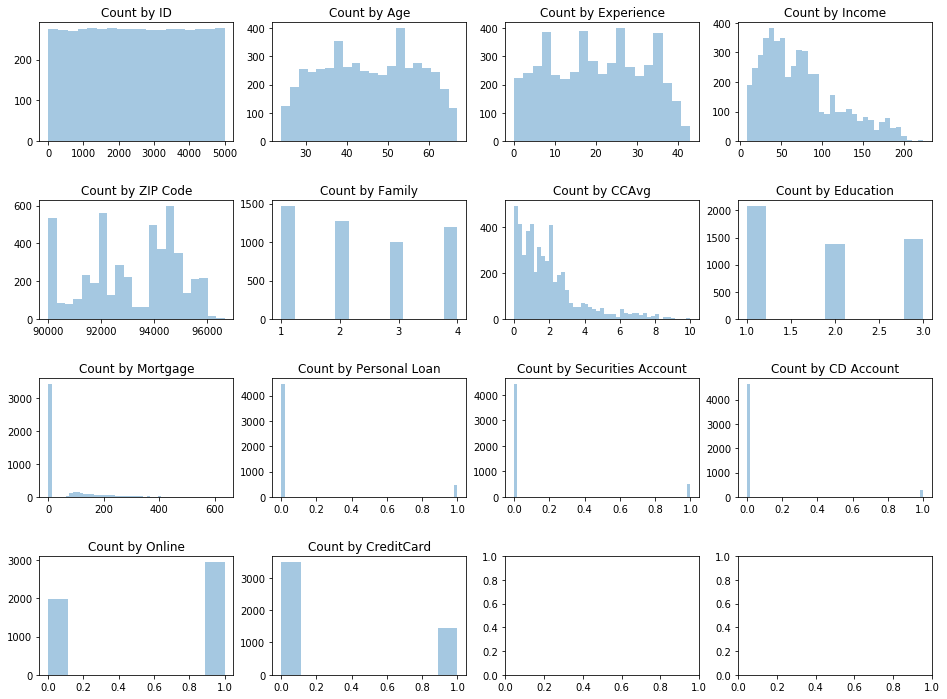

In [34]:
fig, axes = plt.subplots(4, 4, figsize=(16,12))
fig.subplots_adjust(hspace=0.5)

for i in range(list_len):
    sns.distplot(data[column_list[i]], ax=axes.flatten()[i], kde=False)
    axes.flatten()[i].set(title='Count by '+column_list[i], xlabel='')

plt.show()    


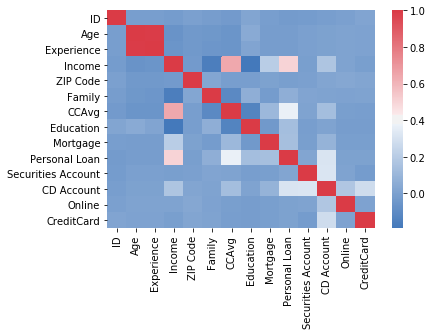

In [35]:
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(data.corr(), cmap = cmap, annot = False)

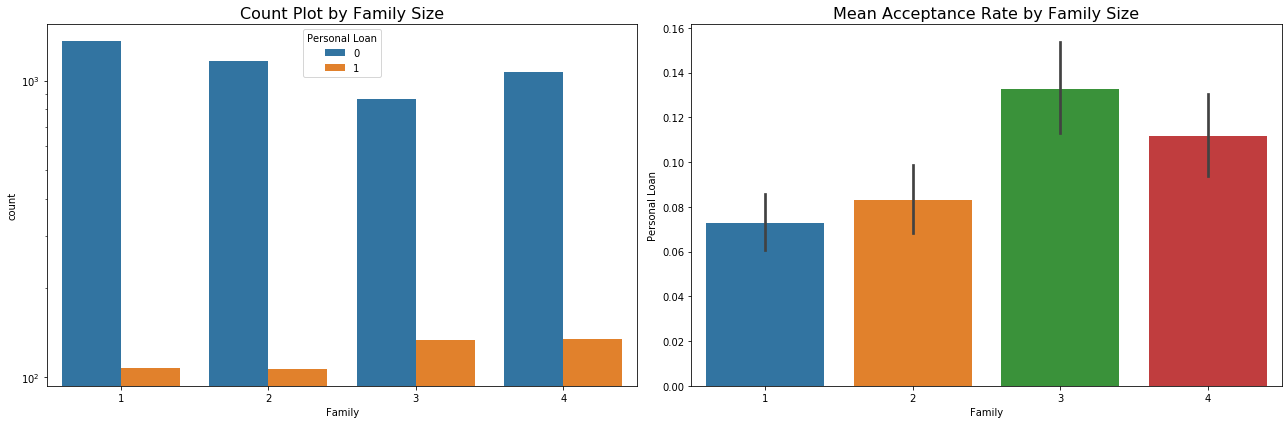

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='Family', hue='Personal Loan', data=data, ax=ax[0])
ax[0].set_title('Count Plot by Family Size', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='Family', y='Personal Loan', data=data, ax=ax[1]);
ax[1].set_title('Mean Acceptance Rate by Family Size', fontsize=16)
plt.tight_layout()
plt.show()

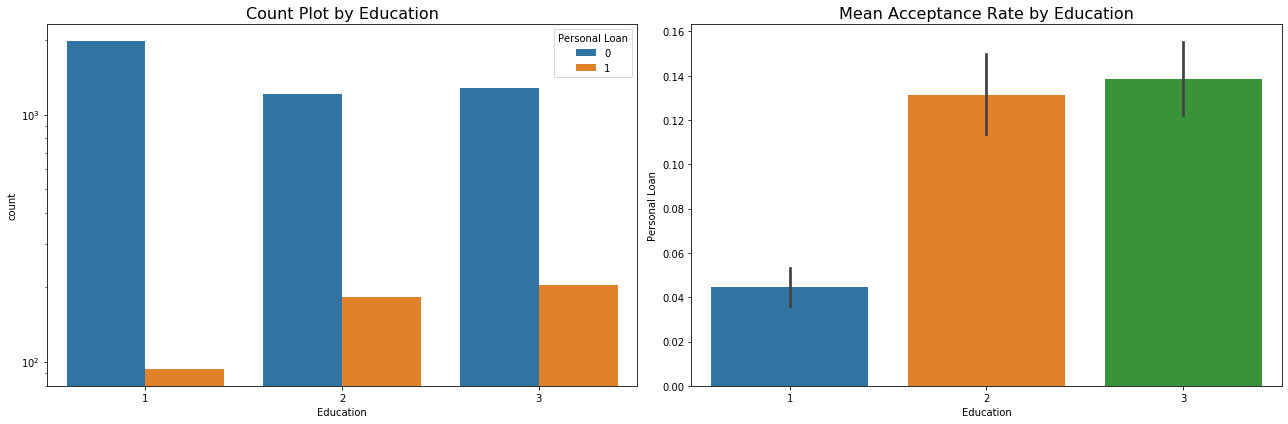

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='Education', hue='Personal Loan', data=data, ax=ax[0])
ax[0].set_title('Count Plot by Education', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='Education', y='Personal Loan', data=data, ax=ax[1]);
ax[1].set_title('Mean Acceptance Rate by Education', fontsize=16)
plt.tight_layout()
plt.show()

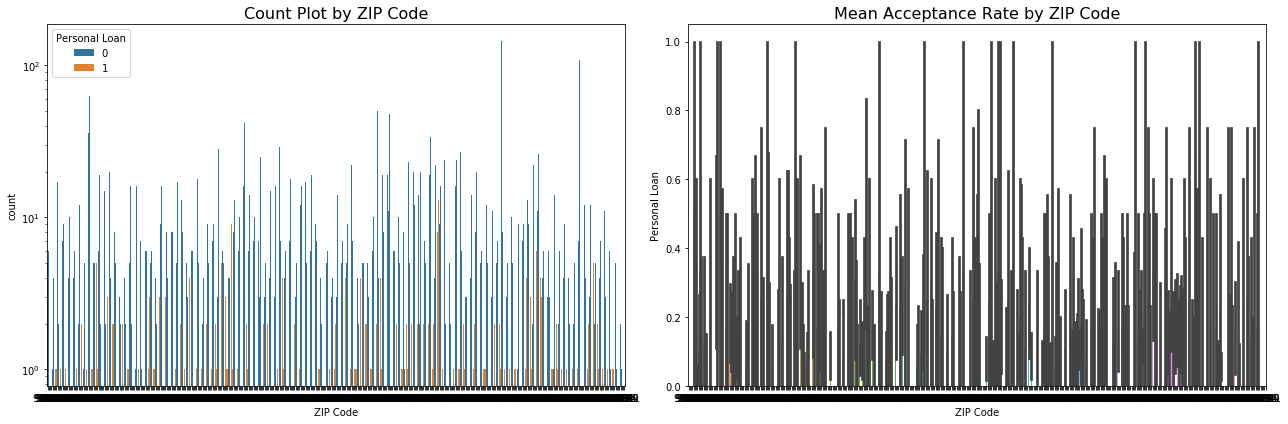

In [14]:
#grouped = data[['ZIP Code', 'Personal Loan']].groupby('ZIP Code').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='ZIP Code', hue='Personal Loan', data=data, ax=ax[0])
ax[0].set_title('Count Plot by ZIP Code', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='ZIP Code', y='Personal Loan', data=data, ax=ax[1]);
ax[1].set_title('Mean Acceptance Rate by ZIP Code', fontsize=16)
plt.tight_layout()
plt.show()

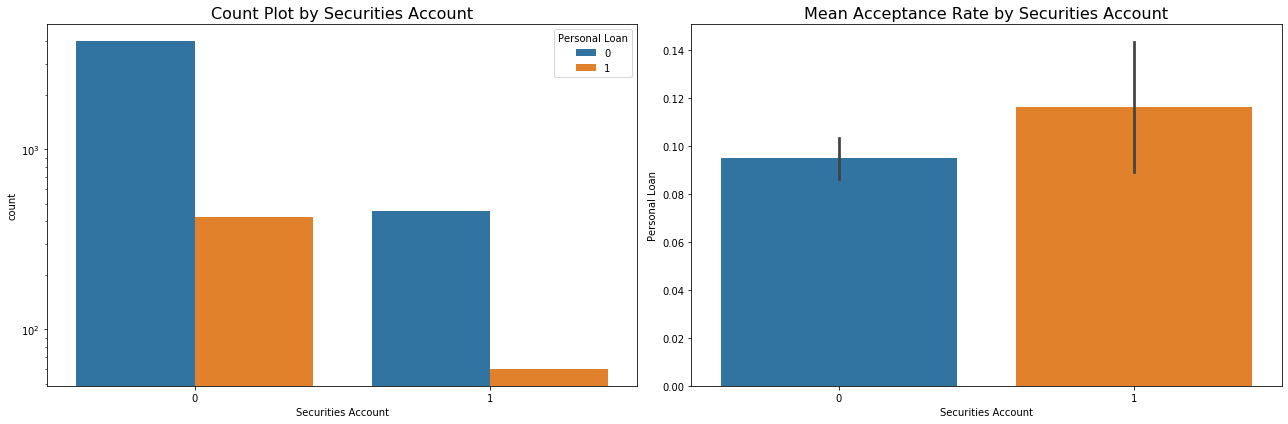

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='Securities Account', hue='Personal Loan', data=data, ax=ax[0])
ax[0].set_title('Count Plot by Securities Account', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='Securities Account', y='Personal Loan', data=data, ax=ax[1]);
ax[1].set_title('Mean Acceptance Rate by Securities Account', fontsize=16)
plt.tight_layout()
plt.show()

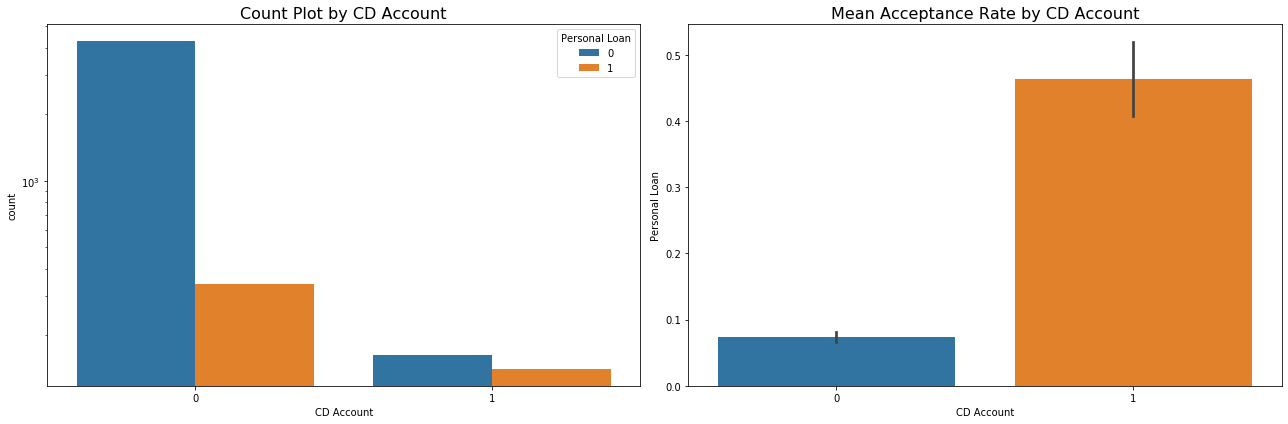

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='CD Account', hue='Personal Loan', data=data, ax=ax[0])
ax[0].set_title('Count Plot by CD Account', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='CD Account', y='Personal Loan', data=data, ax=ax[1]);
ax[1].set_title('Mean Acceptance Rate by CD Account', fontsize=16)
plt.tight_layout()
plt.show()

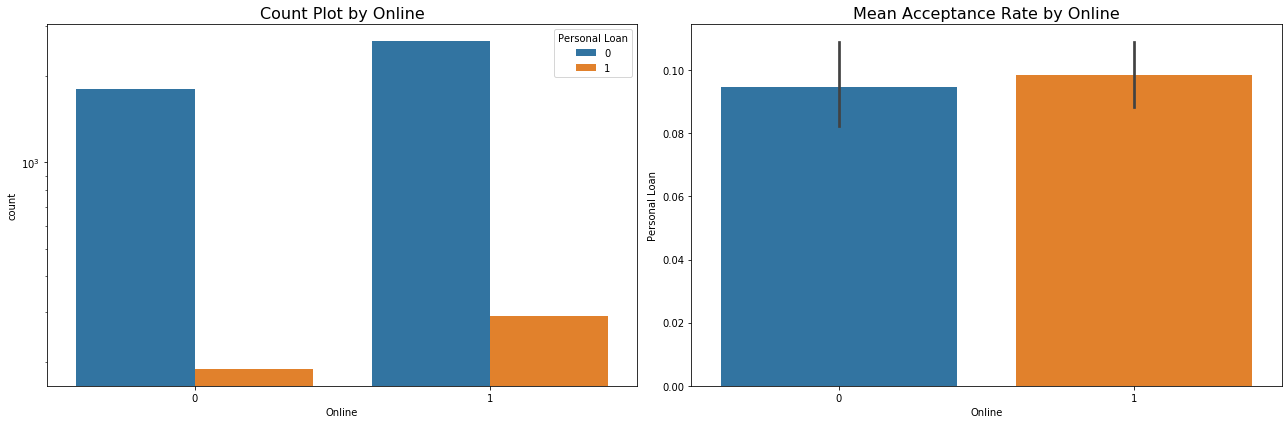

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='Online', hue='Personal Loan', data=data, ax=ax[0])
ax[0].set_title('Count Plot by Online', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='Online', y='Personal Loan', data=data, ax=ax[1]);
ax[1].set_title('Mean Acceptance Rate by Online', fontsize=16)
plt.tight_layout()
plt.show()

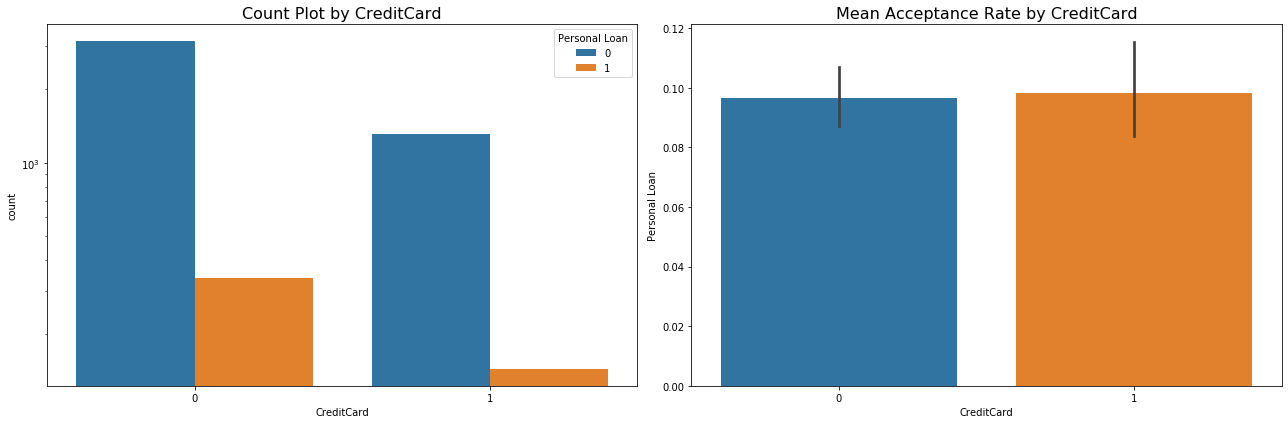

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='CreditCard', hue='Personal Loan', data=data, ax=ax[0])
ax[0].set_title('Count Plot by CreditCard', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='CreditCard', y='Personal Loan', data=data, ax=ax[1]);
ax[1].set_title('Mean Acceptance Rate by CreditCard', fontsize=16)
plt.tight_layout()
plt.show()

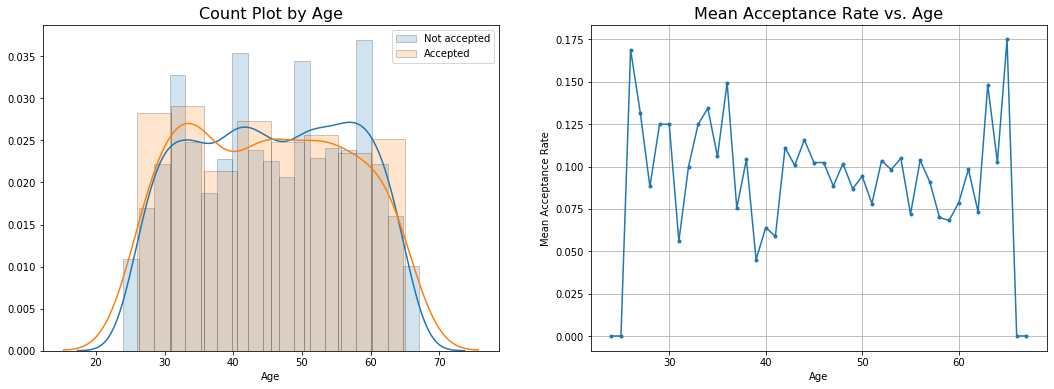

In [19]:
grouped = data[['Age', 'Personal Loan']].groupby('Age').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['Personal Loan'] == 0]['Age'], label='Not accepted', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['Personal Loan'] == 1]['Age'], label='Accepted', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot by Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['Age'], grouped['Personal Loan'], '.-')
ax[1].set_title('Mean Acceptance Rate vs. Age', fontsize=16)
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Mean Acceptance Rate')
ax[1].grid(True)
plt.show()

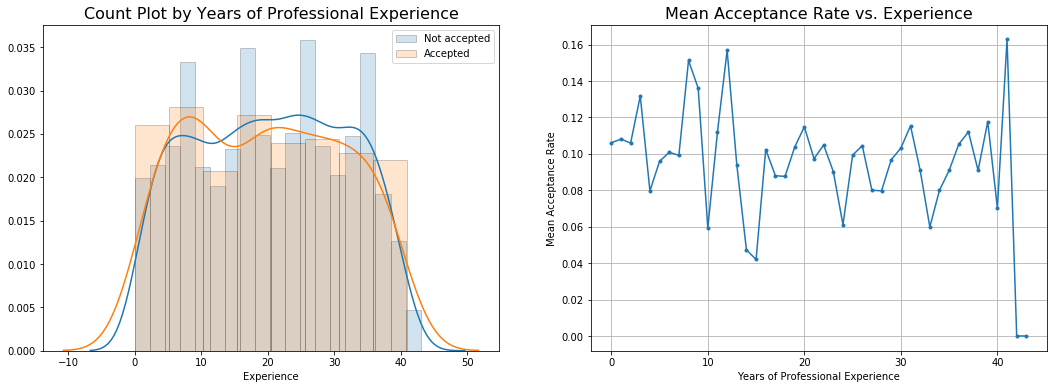

In [20]:
grouped = data[['Experience', 'Personal Loan']].groupby('Experience').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['Personal Loan'] == 0]['Experience'], label='Not accepted', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['Personal Loan'] == 1]['Experience'], label='Accepted', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot by Years of Professional Experience', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['Experience'], grouped['Personal Loan'], '.-')
ax[1].set_title('Mean Acceptance Rate vs. Experience', fontsize=16)
ax[1].set_xlabel('Years of Professional Experience')
ax[1].set_ylabel('Mean Acceptance Rate')
ax[1].grid(True)
plt.show()

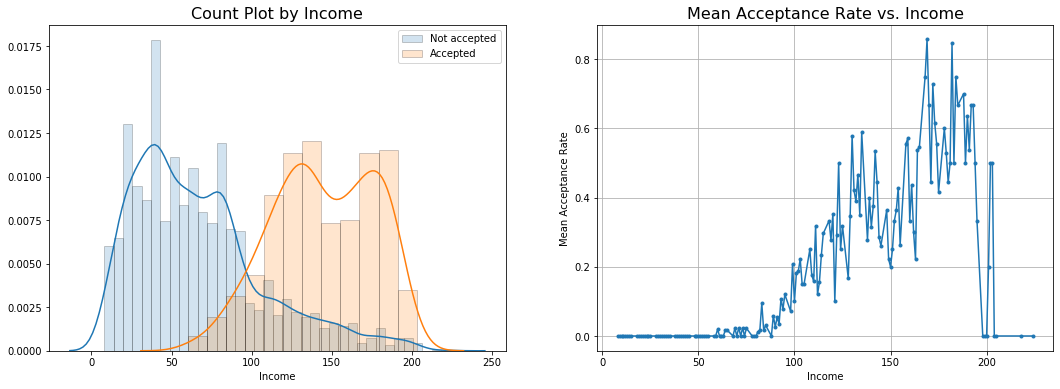

In [21]:
grouped = data[['Income', 'Personal Loan']].groupby('Income').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['Personal Loan'] == 0]['Income'], label='Not accepted', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['Personal Loan'] == 1]['Income'], label='Accepted', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot by Income', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['Income'], grouped['Personal Loan'], '.-')
ax[1].set_title('Mean Acceptance Rate vs. Income', fontsize=16)
ax[1].set_xlabel('Income')
ax[1].set_ylabel('Mean Acceptance Rate')
ax[1].grid(True)
plt.show()

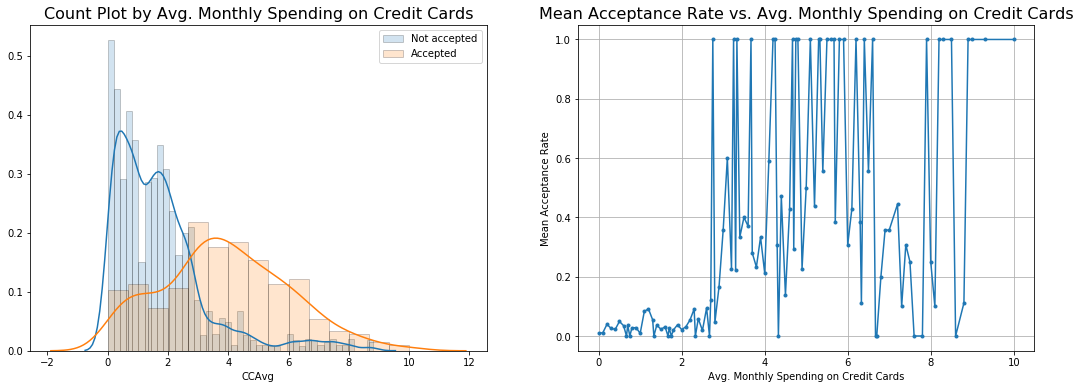

In [22]:
grouped = data[['CCAvg', 'Personal Loan']].groupby('CCAvg').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['Personal Loan'] == 0]['CCAvg'], label='Not accepted', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['Personal Loan'] == 1]['CCAvg'], label='Accepted', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot by Avg. Monthly Spending on Credit Cards', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['CCAvg'], grouped['Personal Loan'], '.-')
ax[1].set_title('Mean Acceptance Rate vs. Avg. Monthly Spending on Credit Cards', fontsize=16)
ax[1].set_xlabel('Avg. Monthly Spending on Credit Cards')
ax[1].set_ylabel('Mean Acceptance Rate')
ax[1].grid(True)
plt.show()

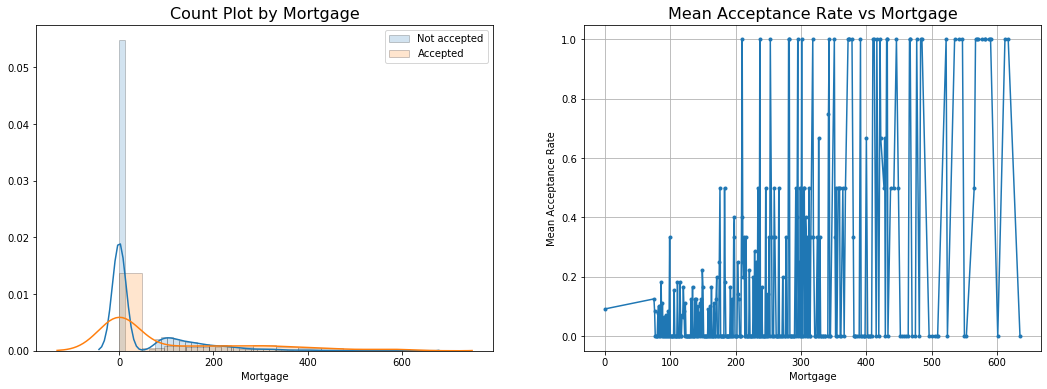

In [23]:
grouped = data[['Mortgage', 'Personal Loan']].groupby('Mortgage').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['Personal Loan'] == 0]['Mortgage'], label='Not accepted', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['Personal Loan'] == 1]['Mortgage'], label='Accepted', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot by Mortgage', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['Mortgage'], grouped['Personal Loan'], '.-')
ax[1].set_title('Mean Acceptance Rate vs Mortgage', fontsize=16)
ax[1].set_xlabel('Mortgage')
ax[1].set_ylabel('Mean Acceptance Rate')
ax[1].grid(True)
plt.show()

#### Build a column called Mortgage_Y, where 0 means customer does not have mortage and 1 means customer has mortage

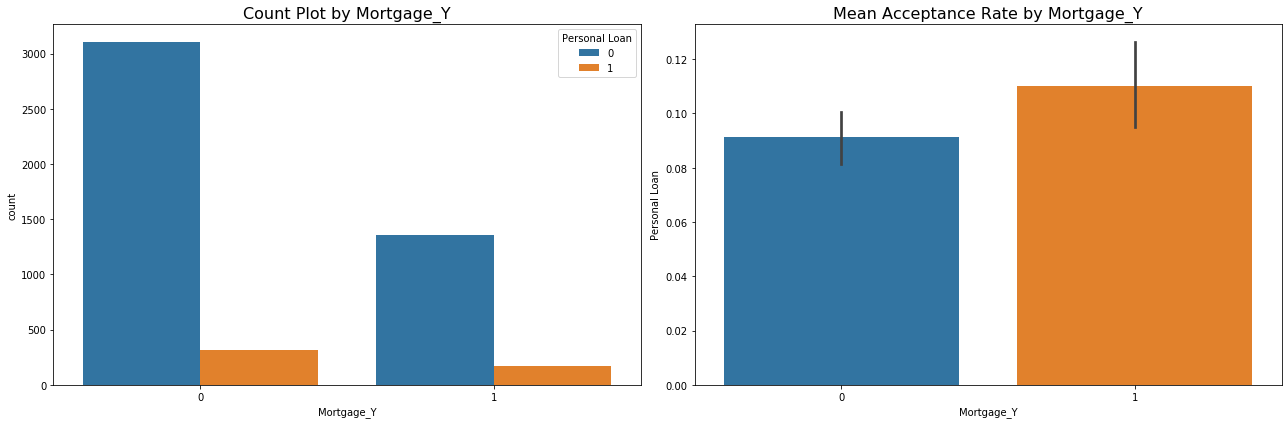

In [24]:
data['Mortgage_Y'] = 0
data.loc[data['Mortgage']>0,'Mortgage_Y']=1

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='Mortgage_Y', hue='Personal Loan', data=data, ax=ax[0])
ax[0].set_title('Count Plot by Mortgage_Y', fontsize=16)
#ax[0].set_yscale('log')
sns.barplot(x='Mortgage_Y', y='Personal Loan', data=data, ax=ax[1]);
ax[1].set_title('Mean Acceptance Rate by Mortgage_Y', fontsize=16)
plt.tight_layout()
plt.show()

<a name="EDA observations and recommendations"></a>
## EDA observations and recommendations

Observation: 
1. Customers with annual income 100K to 200K are much more likely to accept personal loan. Customers with annual income less than 75K are much less likely to accept personal loan.
2. Customers with a CD account are much more likely to accept personal loan.<br>

__Recommendation 1__: Focus on VIP customers with annual income 100K to 200K or with a certificate of deposit account in the bank.

Observation: 
1. Customers with monthly credit card spending more than 3K are more likely to accept personal loan.
2. Customers with family size 3 and 4 are more likely to accept personal loan.
3. Customers with graduate and advanced education are more likely to accept personal loan than undergrad.<br>     

__Recommendation 2__: Focus on customers with monthly credit card spending more than 3K or with a family size of 3 and 4, or with graduate and advanced education.

Observation: 
1. Customers accepting personal loans have a evenly distributed age from 20s to 60s.
2. Customers accepting personal loans have a evenly distributed years of working experience from 0 to 40 years.<br>

__Recommendation 3__: Treat customers equally with different ages or with different years of working experience equally.

Observation: There are 466 unique ZIP codes and it's hard to tell if a customer will accept personal loan or not by zip codes.<br>

__Recommendation 4__: Get more zip code geographical information and cluster them into several big groups.

## Modeling <a name="Modeling"></a>

In [25]:
data['Education_catog']=data['Education'].astype(str)

In [26]:
data_encode = pd.get_dummies(data)

In [27]:
data_encode.columns

Index(['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal Loan', 'Securities Account',
       'CD Account', 'Online', 'CreditCard', 'Mortgage_Y', 'Education_catog_1',
       'Education_catog_2', 'Education_catog_3'],
      dtype='object')

In [28]:
# These columns are not added: ID, ZIP Code, Education, Mortgage
columns = ['Age', 'Experience', 'Income', 'Family', 'CCAvg',
       'Securities Account', 'CD Account', 'Online', 'CreditCard','Mortgage_Y', 'Education_catog_1',
       'Education_catog_2', 'Education_catog_3']
X = data_encode[columns]
y = data_encode['Personal Loan']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Logistic Regression<a name="Logistic Regression"></a>

In [30]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.117822
         Iterations 9
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.630    
Dependent Variable:   Personal Loan     AIC:               1191.7269
Date:                 2020-06-03 23:57  BIC:               1276.3119
No. Observations:     4947              Log-Likelihood:    -582.86  
Df Model:             12                LL-Null:           -1575.6  
Df Residuals:         4934              LLR p-value:       0.0000   
Converged:            1.0000            Scale:             1.0000   
No. Iterations:       9.0000                                        
--------------------------------------------------------------------
                    Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
--------------------------------------------------------------------
Age                 -0.0322   0.0669 -0.4819 0.6298  -0.1633  0.0988
Experience           0.0393 

In [31]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/Andrew/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
print(classification_report(y_train, logreg.predict(X_train)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3139
           1       0.87      0.66      0.75       323

    accuracy                           0.96      3462
   macro avg       0.92      0.83      0.86      3462
weighted avg       0.96      0.96      0.96      3462



In [33]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.9515


In [34]:
confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)

[[1309   19]
 [  53  104]]


In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1328
           1       0.85      0.66      0.74       157

    accuracy                           0.95      1485
   macro avg       0.90      0.82      0.86      1485
weighted avg       0.95      0.95      0.95      1485



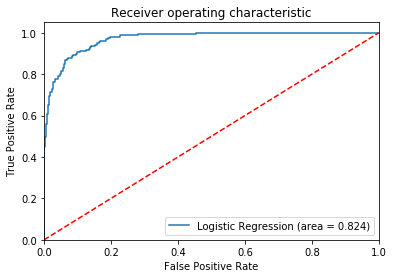

In [36]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.3f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Random Forest<a name="Random Forest"></a>

In [37]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42, oob_score = True)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [38]:
rf.oob_score_

0.987001733102253

In [39]:
print(classification_report(y_train, rf.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3139
           1       1.00      1.00      1.00       323

    accuracy                           1.00      3462
   macro avg       1.00      1.00      1.00      3462
weighted avg       1.00      1.00      1.00      3462



In [40]:
y_pred = rf.predict(X_test)

In [41]:
confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)

[[1326    2]
 [  14  143]]


In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1328
           1       0.99      0.91      0.95       157

    accuracy                           0.99      1485
   macro avg       0.99      0.95      0.97      1485
weighted avg       0.99      0.99      0.99      1485



In [43]:
importances = list(rf.feature_importances_)
features = list(X.columns)

feature_importance = [(f, i) for f, i in zip(features, importances)]
feature_importance = sorted(feature_importance, key = lambda x: x[1], reverse = True)
print("Features and Importances: ")
s = [print("{0:s}: {1:4.3f}".format(*p)) for p in feature_importance]

Features and Importances: 
Income: 0.362
CCAvg: 0.197
Education_catog_1: 0.116
Family: 0.094
CD Account: 0.050
Experience: 0.042
Age: 0.041
Education_catog_3: 0.038
Education_catog_2: 0.030
Online: 0.009
CreditCard: 0.008
Mortgage_Y: 0.007
Securities Account: 0.006


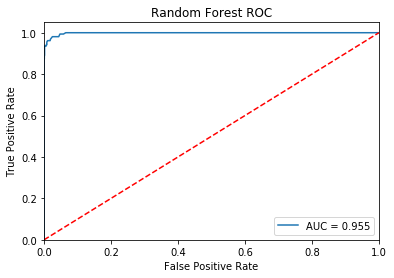

In [44]:
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC')
plt.legend(loc="lower right")

plt.show()

#### From the ROC, we know we can tune threshold to increase TPR (recall) to 0.9-0.95 without decreasing FPR too much.
#### Following cell is one example of tuning threshold

In [45]:
for threshold in [0.25+i/10 for i in range(3)]:

    predicted_proba = rf.predict_proba(X_test)
    predicted = (predicted_proba [:,1] >= threshold).astype('int')

    print("Threshold is", threshold)
    print(classification_report(y_test, predicted))

Threshold is 0.25
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1328
           1       0.93      0.94      0.94       157

    accuracy                           0.99      1485
   macro avg       0.96      0.97      0.96      1485
weighted avg       0.99      0.99      0.99      1485

Threshold is 0.35
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1328
           1       0.97      0.94      0.95       157

    accuracy                           0.99      1485
   macro avg       0.98      0.97      0.97      1485
weighted avg       0.99      0.99      0.99      1485

Threshold is 0.45
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1328
           1       0.99      0.92      0.95       157

    accuracy                           0.99      1485
   macro avg       0.99      0.96      0.97      1485
weighted avg       0

<a name="RF model using oversampled data"></a>
### RF model using oversampled data 
#### Data is imbalanced because accepted personal loan records account for 10% data. Using oversampled data, new RF model's AUC is slightly improved (0.957 vs 0.955)

In [46]:
len(y_train[y_train == 1])

323

In [47]:
len(y_train[y_train == 0])

3139

In [48]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [49]:
len(y_res[y_res==1])

3139

In [50]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42, oob_score = True)
rf.fit(X_res, y_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [51]:
rf.oob_score_

0.9928321121376235

In [52]:
print(classification_report(y_res, rf.predict(X_res)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3139
           1       1.00      1.00      1.00      3139

    accuracy                           1.00      6278
   macro avg       1.00      1.00      1.00      6278
weighted avg       1.00      1.00      1.00      6278



In [53]:
y_pred = rf.predict(X_test)

In [54]:
confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)

[[1324    4]
 [  13  144]]


In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1328
           1       0.97      0.92      0.94       157

    accuracy                           0.99      1485
   macro avg       0.98      0.96      0.97      1485
weighted avg       0.99      0.99      0.99      1485



In [56]:
importances = list(rf.feature_importances_)
features = list(X_res.columns)

feature_importance = [(f, i) for f, i in zip(features, importances)]
feature_importance = sorted(feature_importance, key = lambda x: x[1], reverse = True)
print("Features and Importances: ")
s = [print("{0:s}: {1:4.3f}".format(*p)) for p in feature_importance]

Features and Importances: 
Income: 0.437
CCAvg: 0.219
Education_catog_1: 0.167
Family: 0.037
Education_catog_2: 0.021
Online: 0.021
Age: 0.020
Experience: 0.020
CreditCard: 0.017
Education_catog_3: 0.016
CD Account: 0.012
Securities Account: 0.007
Mortgage_Y: 0.006


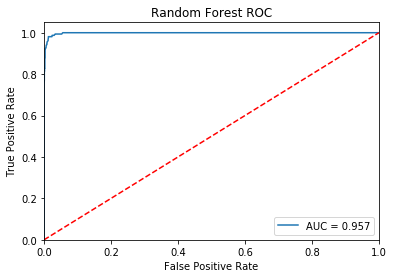

In [57]:
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

### Modeling Conclusion<a name="Modeling Conclusion"></a>

Random Forest Classifier can predict personal loan acceptance more accurately than Logistic Regression classifier (model AUC 0.96 Vs 0.82). Oversampled training data slightly improved Random Forest classifier (AUC 0.957 vs 0.955)